## Predict Plant Seedling using Convolution Neural Networks

Dataset: https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset

Successful cultivation of maize depends largely on the efficacy of weed control. The goal of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

In [2]:
# to handle datasets
import pandas as pd
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")
# import warnings
# warnings.simplefilter("ignore", category=PendingDeprecationWarning)
 

import seaborn as sns

# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
# Define out image folder
DATA_FOLDER = 'v2-plant-seedlings-dataset'

In [4]:
# each weed class is saved in a folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherd’s Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

In [6]:
# Display the directory structure

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
#     for image_path in glob(os.path.join(class_folder_path, "*.png")):
#         print(image_path[:5])

In [5]:
# let's create a dataframe to store the image path and its corresponding weed specicies
images_df = []

# navigate within each folder for each weed
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # collect all the image paths
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,v2-plant-seedlings-dataset/Common wheat/128.png,Common wheat
1,v2-plant-seedlings-dataset/Common wheat/23.png,Common wheat
2,v2-plant-seedlings-dataset/Common wheat/13.png,Common wheat
3,v2-plant-seedlings-dataset/Common wheat/3.png,Common wheat
4,v2-plant-seedlings-dataset/Common wheat/125.png,Common wheat
5,v2-plant-seedlings-dataset/Common wheat/25.png,Common wheat
6,v2-plant-seedlings-dataset/Common wheat/229.png,Common wheat
7,v2-plant-seedlings-dataset/Common wheat/79.png,Common wheat
8,v2-plant-seedlings-dataset/Common wheat/234.png,Common wheat
9,v2-plant-seedlings-dataset/Common wheat/186.png,Common wheat


In [6]:
print("Number of images for each specy")

images_df['target'].value_counts()

Number of images for each specy


Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
ShepherdтАЩs Purse           274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [7]:
# An example of image path

images_df.loc[0, 'image']

'v2-plant-seedlings-dataset/Common wheat/128.png'

A few examples of images


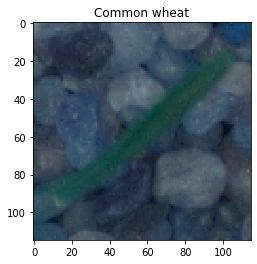

In [8]:
print("A few examples of images")

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

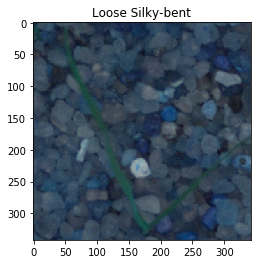

In [9]:
plot_single_image(images_df, 3000)

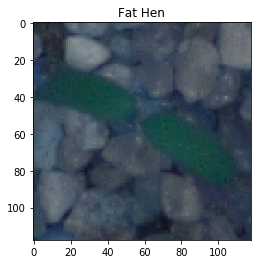

In [10]:
plot_single_image(images_df, 1000)

In [11]:
print("Examples of images for a few species")

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

Examples of images for a few species


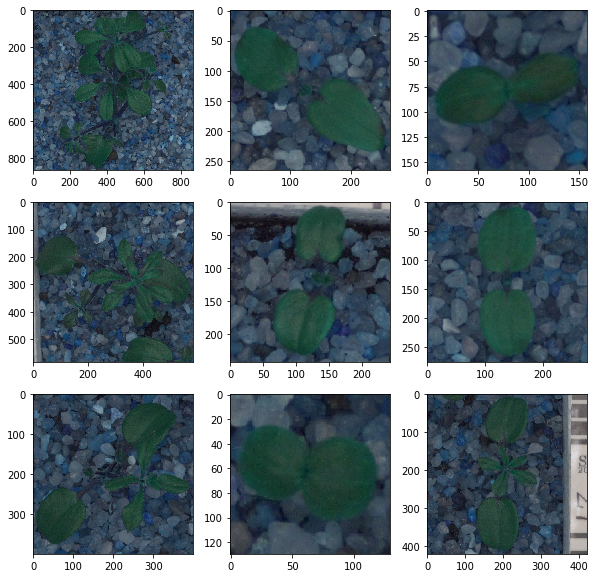

In [12]:
plot_for_class(images_df, 'Cleavers')

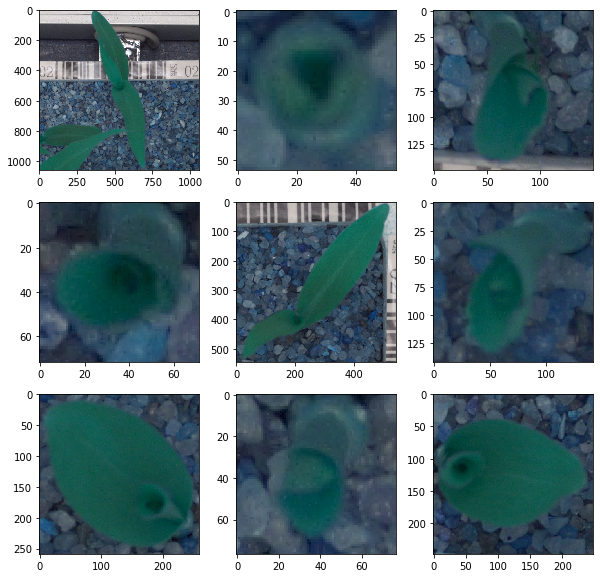

In [13]:
plot_for_class(images_df, 'Maize')

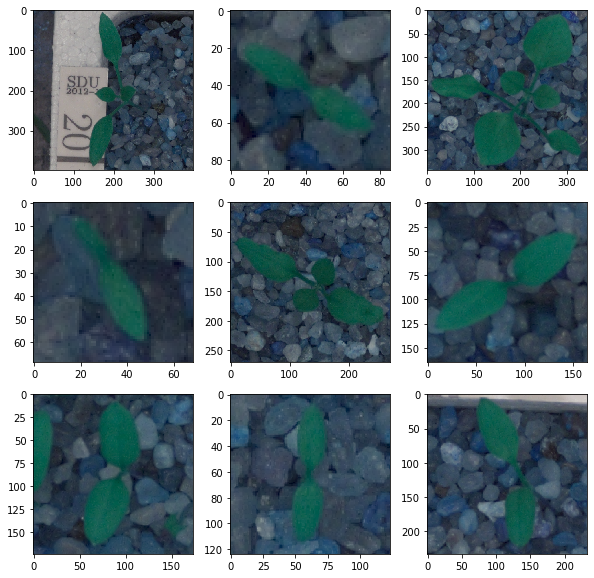

In [14]:
plot_for_class(images_df, 'Common Chickweed')

### Separate train and test

In [15]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], test_size=0.20, random_state=101)

print(f'Number of images in the trainning set: {X_train.shape[0]}')
print(f'Number of images in the testing set: {X_test.shape[0]}')

Number of images in the trainning set: 4431
Number of images in the testing set: 1108


In [16]:
# the indeces of the training data are mixed
# this will cause problems later

X_train.head()

1922    v2-plant-seedlings-dataset/Scentless Mayweed/4...
4164             v2-plant-seedlings-dataset/Maize/199.png
2952    v2-plant-seedlings-dataset/Loose Silky-bent/39...
287           v2-plant-seedlings-dataset/Charlock/336.png
4971    v2-plant-seedlings-dataset/Small-flowered Cran...
Name: image, dtype: object

In [17]:
# reset index

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    v2-plant-seedlings-dataset/Scentless Mayweed/4...
1             v2-plant-seedlings-dataset/Maize/199.png
2    v2-plant-seedlings-dataset/Loose Silky-bent/39...
3          v2-plant-seedlings-dataset/Charlock/336.png
4    v2-plant-seedlings-dataset/Small-flowered Cran...
Name: image, dtype: object

In [18]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [19]:
# percentage of images within each class

y_train.value_counts() / len(y_train)

Loose Silky-bent             0.134733
Common Chickweed             0.127962
Scentless Mayweed            0.110133
Small-flowered Cranesbill    0.103814
Fat Hen                      0.097269
Sugar beet                   0.083503
Charlock                     0.082374
Cleavers                     0.060709
Black-grass                  0.055518
ShepherdтАЩs Purse           0.049650
Maize                        0.049425
Common wheat                 0.044911
Name: target, dtype: float64

In [20]:
# should be the same in the test set

y_test.value_counts() / len(y_test)

Loose Silky-bent             0.148917
Common Chickweed             0.131769
Scentless Mayweed            0.107401
Small-flowered Cranesbill    0.104693
Fat Hen                      0.096570
Sugar beet                   0.083935
Charlock                     0.078520
Cleavers                     0.059567
Black-grass                  0.056859
Common wheat                 0.048736
ShepherdтАЩs Purse           0.048736
Maize                        0.034296
Name: target, dtype: float64

In [21]:
# Transform the target into categorical using one hot encoder

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [22]:
# resize the image into 150 x 150

IMAGE_SIZE = 150

In [23]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [24]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

In [25]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes (RGB) per image

def create_dataset(df, image_size):
    # reshape the data into desired size
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [26]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [27]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [28]:
# number of different classes

len(y_train.unique())

12

In [31]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# import warnings
# warnings.filterwarnings("ignore")

# Here is the CNN model

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 70, 70, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 68, 68, 64)        36928     
__________

In [32]:
# compile the model
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# import warnings
# warnings.filterwarnings("ignore")

model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [33]:
# specify batch size and number of epochs
batch_size = 10
epochs = 8

In [36]:
# the path to save the trainned model
filepath = "model.h5"

# checkpoint to save the status of trainning
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')

# learning rate reduce strategy
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

# save the training into trainning
history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size, 
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/8
 - 208s - loss: 0.2777 - acc: 0.9157

Epoch 00001: acc improved from -inf to 0.91575, saving model to model.h5
Epoch 2/8
 - 218s - loss: 0.1787 - acc: 0.9317

Epoch 00002: acc improved from 0.91575 to 0.93167, saving model to model.h5
Epoch 3/8
 - 209s - loss: 0.1371 - acc: 0.9472

Epoch 00003: acc improved from 0.93167 to 0.94715, saving model to model.h5
Epoch 4/8
 - 207s - loss: 0.1149 - acc: 0.9568

Epoch 00004: acc improved from 0.94715 to 0.95676, saving model to model.h5
Epoch 5/8
 - 207s - loss: 0.0956 - acc: 0.9642

Epoch 00005: acc improved from 0.95676 to 0.96415, saving model to model.h5
Epoch 6/8
 - 207s - loss: 0.0789 - acc: 0.9705

Epoch 00006: acc improved from 0.96415 to 0.97055, saving model to model.h5
Epoch 7/8
 - 207s - loss: 0.0640 - acc: 0.9758

Epoch 00007: acc improved from 0.97055 to 0.97578, saving model to model.h5
Epoch 8/8
 - 207s - loss: 0.0535 - acc: 0.9797

Epoch 00008: acc improved from 0.97578 to 0.97969, saving model to model.h5


<Figure size 432x288 with 0 Axes>

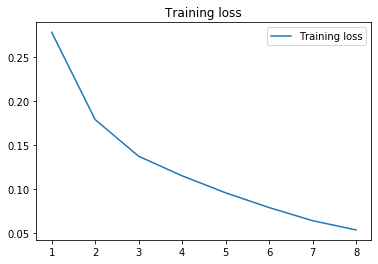

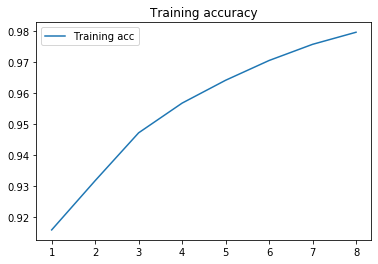

<Figure size 432x288 with 0 Axes>

In [37]:
# visulize the trainning curve
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [38]:
# make a prediction

predictions = model.predict_classes(x_test, verbose=1)

1108/1108 [==============================] - 9s 8ms/step


In [39]:
# inspect predictions
predictions

array([3, 4, 1, ..., 6, 2, 8])

In [40]:
# transform target
encoder.transform(y_test)

array([ 3,  4,  9, ...,  6, 11,  8])

In [41]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [42]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

{3: 'Common Chickweed',
 4: 'Common wheat',
 9: 'ShepherdтАЩs Purse',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 1: 'Charlock',
 0: 'Black-grass',
 8: 'Scentless Mayweed',
 11: 'Sugar beet',
 2: 'Cleavers',
 10: 'Small-flowered Cranesbill'}

In [43]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

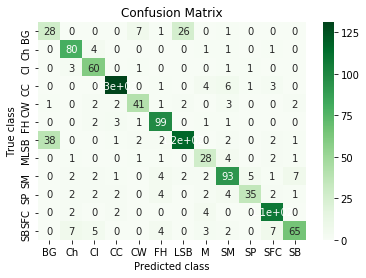

In [44]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [45]:
accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

0.7987364620938628

In [46]:
print(classification_report(encoder.transform(y_test), predictions))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43        63
           1       0.82      0.92      0.87        87
           2       0.78      0.91      0.84        66
           3       0.92      0.90      0.91       146
           4       0.77      0.76      0.77        54
           5       0.85      0.93      0.88       107
           6       0.80      0.71      0.75       165
           7       0.62      0.74      0.67        38
           8       0.79      0.78      0.78       119
           9       0.83      0.65      0.73        54
          10       0.86      0.93      0.89       116
          11       0.84      0.70      0.76        93

    accuracy                           0.80      1108
   macro avg       0.78      0.78      0.77      1108
weighted avg       0.80      0.80      0.80      1108

